In [2]:
pip install yfinance pandas matplotlib ta backtrader vectorbt numpy==2.2.0

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install --upgrade vectorbt

Note: you may need to restart the kernel to use updated packages.


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_10996/554513402.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period=data_period, interval=data_interval, progress=False).dropna()


————— Trade Metrics —————
Parameters            : SMA(20,50), Trailing Stop = 1.0%
Total Trades          : 66
Profitable Trades     : 21
Win Rate              : 31.82 %
Average PnL per Trade : ₹106.45
Average Return/Trade  : 0.11 %
Largest Win           : ₹7226.76
Largest Loss          : ₹-1169.39
Final Portfolio Value : ₹107,025.50



<Figure size 1200x600 with 0 Axes>

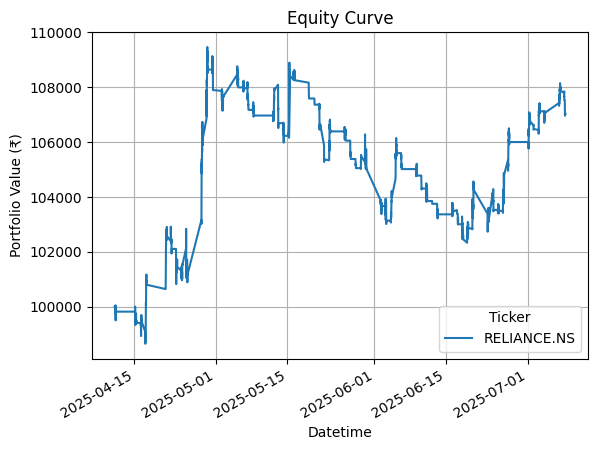

Trades exported to trades_integer_sizes.csv (timestamps in IST)


In [1]:
import vectorbt as vbt
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pytz

# ─── CONFIG ────────────────────────────────────────────────────────────────
symbol      = 'RELIANCE.NS'
init_cash   = 100_000           # ₹100 000 starting capital
fees        = 0.0002            # 0.02% commission per trade
slippage    = 0.0001            # 0.01% slippage per trade
sma_short   = 20                # Fast SMA window
sma_long    = 50                # Slow SMA window
trail_stop  = 0.01              # 1% trailing stop
data_period = '60d'             # Lookback
data_interval = '5m'            # Granularity
# ────────────────────────────────────────────────────────────────────────────

# 1) Fetch price data
df = yf.download(symbol, period=data_period, interval=data_interval, progress=False).dropna()

price = df['Close']

# 2) Compute SMAs
fast_ma = price.rolling(sma_short).mean()
slow_ma = price.rolling(sma_long).mean()

# 3) Entry / exit boolean signals
entries = fast_ma > slow_ma
exits   = fast_ma < slow_ma

# 4) Build integer-share size series
raw_size = init_cash / price
size = np.floor(raw_size).astype(int)    # round down to whole shares
size[size < 1] = 0                       # can't buy less than 1 share

# 5) Backtest with trailing stop using sl_stop & sl_trail
pf = vbt.Portfolio.from_signals(
    close      = price,
    entries    = entries,
    exits      = exits,
    init_cash  = init_cash,
    size       = size,        # integer shares
    fees       = fees,
    slippage   = slippage,
    sl_stop    = trail_stop,  # absolute fractional stop
    sl_trail   = True         # make it trailing
)

# 6) Extract trades and compute ReturnPct if missing
trades = pf.trades.records_readable.copy()
trades['Size'] = trades['Size'].round().astype(int)
if 'ReturnPct' not in trades.columns:
    trades['ReturnPct'] = trades['PnL'] / (abs(trades['Size'] * trades['Avg Entry Price'])) * 100

# 7) Compute metrics
total_trades      = len(trades)
profitable_trades = (trades['PnL'] > 0).sum()
win_rate          = profitable_trades / total_trades * 100 if total_trades else 0
avg_pnl           = trades['PnL'].mean() if total_trades else 0
avg_return_pct    = trades['ReturnPct'].mean() if total_trades else 0
max_win           = trades['PnL'].max() if total_trades else 0
max_loss          = trades['PnL'].min() if total_trades else 0
final_capital     = pf.value().iloc[-1].item()

# 8) Print metrics
print("————— Trade Metrics —————")
print(f"Parameters            : SMA({sma_short},{sma_long}), Trailing Stop = {trail_stop*100:.1f}%")
print(f"Total Trades          : {total_trades}")
print(f"Profitable Trades     : {profitable_trades}")
print(f"Win Rate              : {win_rate:.2f} %")
print(f"Average PnL per Trade : ₹{avg_pnl:.2f}")
print(f"Average Return/Trade  : {avg_return_pct:.2f} %")
print(f"Largest Win           : ₹{max_win:.2f}")
print(f"Largest Loss          : ₹{max_loss:.2f}")
print(f"Final Portfolio Value : ₹{final_capital:,.2f}\n")

# 9) Plot equity curve
plt.figure(figsize=(12,6))
pf.value().plot(title="Equity Curve", ylabel="Portfolio Value (₹)")
plt.grid(True)
plt.show()

# 10) Export trades in IST to CSV
trades_ist = trades.copy()


for col in ['Entry Timestamp', 'Exit Timestamp']:
    if col in trades_ist:
        trades_ist[col] = pd.to_datetime(trades_ist[col], utc=True).dt.tz_convert('Asia/Kolkata')
trades_ist.to_csv('trades_integer_sizes.csv', index=False)
print("Trades exported to trades_integer_sizes.csv (timestamps in IST)")
